In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import itertools
from collections import defaultdict, OrderedDict
from random import shuffle
from tqdm import tqdm_notebook as tqdm, tnrange as trange
from sklearn.metrics import confusion_matrix

from evalResult import get_predicted, get_observed
plt.style.use('seaborn')

In [2]:
dataset = 'EN'

## Hyperparameters
Here for easy tuning.

In [3]:
# optimal 1e-4
lr = 5e-4
batch_size = 16
n_epochs = 20

## Data

### Cleaning
Prepare words for cleaning. Specifically, find
1. ~~stopwords~~
1. punctuation
1. hashtags
1. @ mentions
1. numbers
1. URLs

In [4]:
re_punc = r'^[^a-zA-Z0-9]+$'
re_hash = r'^#'
re_at = r'^@'
re_num = r'\d'  # just remove all words with numbers
re_url = r'(^http:|\.com$)'

In [5]:
def clean_word(w):
    w = w.strip()
    if re.match(re_punc, w):
        return '#PUNC#'
    if re.match(re_hash, w):
        return '#HASH#'
    if re.match(re_at, w):
        return '#AT#'
    if re.match(re_num, w):
        return '#NUM#'
    if re.match(re_url, w):
        return '#URL#'
    return w.lower()

### I/O

In [6]:
def parse(train_filename):
    with open(train_filename, 'r') as f:
        lines = f.readlines()

    observations, states = defaultdict(int), defaultdict(int)
    for line in lines:
        data_split = line.strip().rsplit(' ', 1)
        if len(data_split) == 2:
            obs, state = data_split
            observations[clean_word(obs)] += 1
            states[state] += 1
    return observations, states

In [7]:
def read_file(filename, clean=True):
    with open(filename, 'r') as f:
        lines = f.readlines()
        
    sentence, label = [], []
    sentences, labels = [], []
    for line in lines:
        data_split = line.strip().rsplit(' ', 1)
        if len(data_split) == 2:
            word, state = data_split
            if clean:
                word = clean_word(word)
            sentence.append(word)
            label.append(state)
        else:
            sentences.append(sentence)
            labels.append(label)
            sentence = []
            label = []
    return sentences, labels

### Train data

In [8]:
train_filename = f'data/{dataset}/train'

observations, states = parse(train_filename)

In [9]:
train_sentences, train_labels = read_file(train_filename)
train_sentences[0][:5], train_labels[0][:5]

(['rt', '#AT#', '#PUNC#', 'encore', '#PUNC#'], ['O', 'O', 'O', 'B-INTJ', 'O'])

### Validation data

In [10]:
val_filename = f'data/{dataset}/dev.out'
val_sentences, val_labels = read_file(val_filename)
val_sentences[0][:5], val_labels[0][:5]

(['no', 'saints', 'r', '#PUNC#', 'buch'],
 ['B-NP', 'I-NP', 'I-NP', 'O', 'B-NP'])

In [11]:
out_filename = f'data/{dataset}/dev.p5.out'

## Split classes

In [12]:
states

defaultdict(int,
            {'O': 2191,
             'B-INTJ': 257,
             'B-PP': 716,
             'B-NP': 2768,
             'I-NP': 1904,
             'B-VP': 1327,
             'B-PRT': 85,
             'I-VP': 607,
             'B-ADJP': 159,
             'B-SBAR': 71,
             'B-ADVP': 386,
             'I-INTJ': 88,
             'B-CONJP': 2,
             'I-CONJP': 2,
             'I-ADVP': 51,
             'I-ADJP': 61,
             'I-SBAR': 4,
             'I-PP': 6})

In [13]:
def convert_state(state):
    if state == 'O':
        return (state, state)
    return state.split('-')


entities = defaultdict(int)
entity_types = defaultdict(int)

for state, counts in states.items():
    e, e_type = convert_state(state)
    entities[e] += counts
    entity_types[e_type] += counts

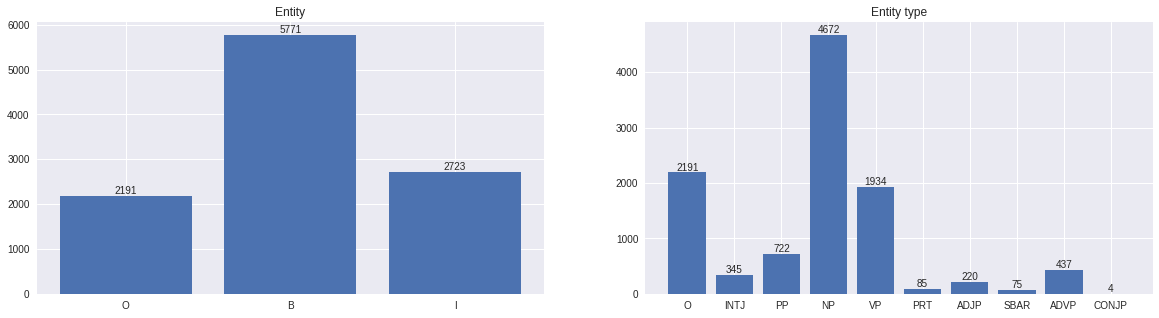

In [14]:
x1, y1 = zip(*entities.items())
x2, y2 = zip(*entity_types.items())

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.title('Entity')
bar1 = plt.bar(x1, y1)
for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x()+rect.get_width()/2, height, str(height), ha='center', va='bottom')

plt.subplot(1, 2, 2)
plt.title('Entity type')
bar2 = plt.bar(x2, y2)
for rect in bar2:
    height = rect.get_height()
    plt.text(rect.get_x()+rect.get_width()/2, height, str(height), ha='center', va='bottom')

## Encoding

In [15]:
def one_hot_encode(n, depth):
    a = np.zeros([depth, 1])
    a[n, 0] = 1
    return a

### Encode words
Create a vocabulary out of words that appear more than `1` time(s) in training. Each word now maps to an _integer_. Other words will be treated as `#UNK#`.

In [16]:
def tokenize(token_mapping, sentence):
    """
    Function to convert each word into its corresponding integer
    If word is not found, return the value for '#UNK'
    """
    return [token_mapping.get(w, token_mapping['#UNK#']) for w in sentence]

def prepare_inputs(token_mapping, sentences):
    """
    Converts a 2-D list of sentences (list of list of words)
    to one-hot encoded tokens of shape [n_sentences, n_words, len(token_mapping), 1].
    """
    tokens = [tokenize(token_mapping, sentence) for sentence in sentences] 
    
    depth = len(token_mapping)
    one_hot_tokens = [[one_hot_encode(token, depth) for token in sentence] for sentence in tokens]
    one_hot_tokens = [np.asarray(ls) for ls in one_hot_tokens]  # list of [n_words, len(token_mapping), 1]
    return one_hot_tokens

In [17]:
min_freq = 0

token_mapping = {}
for word in observations:
    if observations[word] > min_freq:  # appears more than once in training
        token_mapping[word] = len(token_mapping)
token_mapping['#UNK#'] = len(token_mapping)
len(token_mapping)

2504

In [18]:
X_train = prepare_inputs(token_mapping, train_sentences)
len(X_train), X_train[0].shape

(551, (25, 2504, 1))

### Encode labels
Perform a similar encoding for the states:
1. Map to integer
1. Convert from integer to one-hot-encoding

In [19]:
def prepare_labels(entity_mapping, entity_type_mapping, sequences):
    """
    Convert each state from str to its corresponding int value.
    Convert the int to a one-hot vector.
    """
    # code simplicity over code efficiency
    encoded_entities = [[entity_mapping[convert_state(state)[0]] for state in label] for label in sequences]
    encoded_e_types = [[entity_type_mapping[convert_state(state)[1]] for state in label] for label in sequences]
    
    depth = len(entity_mapping)
    one_hot_entities = [[one_hot_encode(label, depth) for label in sequence] for sequence in encoded_entities]
    one_hot_entities = [np.asarray(ls) for ls in one_hot_entities]
    
    depth = len(entity_type_mapping)
    one_hot_e_types = [[one_hot_encode(label, depth) for label in sequence] for sequence in encoded_e_types]
    one_hot_e_types = [np.asarray(ls) for ls in one_hot_e_types]
    return one_hot_entities, one_hot_e_types

In [20]:
entity_mapping = {entity: i for i, entity in enumerate(entities)}
entity_type_mapping = {e_type: i for i, e_type in enumerate(entity_types)}

In [21]:
y1_train, y2_train = prepare_labels(entity_mapping, entity_type_mapping, train_labels)
len(y1_train), y1_train[0].shape, len(y2_train), y2_train[0].shape

(551, (25, 3, 1), 551, (25, 10, 1))

### Validation
Perform a similar encoding for validation data, based on the states and tokens of the training data.

In [22]:
X_val = prepare_inputs(token_mapping, val_sentences)
y1_val, y2_val = prepare_labels(entity_mapping, entity_type_mapping, val_labels)

## RNN
$$
    a^{(t)} = b + Wh^{(t-1)} + Ux^{(t)} \\
    h^{(t)} = \text{tanh}(a^{(t)}) \\
    \\
    o^{(t)} = c + Vh^{(t)} \\
    \hat{y}^{(t)} = \text{softmax}(o^{(t)})
$$

In [23]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

### Initialization

In [24]:
np.random.seed(0)

rnn_size = 128
# input
U = np.random.normal(0, 0.1, size=[rnn_size, len(token_mapping)])
# hidden layer
W = np.random.normal(0, 0.1, size=[rnn_size, rnn_size])
b = np.ones(shape=[rnn_size, 1]) * 0.1
# output - entity
V1 = np.random.normal(0, 0.1, size=[len(entity_mapping), rnn_size])
c1 = np.ones(shape=[len(entity_mapping), 1]) * 0.1
# output - entity type
V2 = np.random.normal(0, 0.1, size=[len(entity_type_mapping), rnn_size])
c2 = np.ones(shape=[len(entity_type_mapping), 1]) * 0.1

In [25]:
model = (U, W, b, V1, c1, V2, c2)  # time for some unpacking magic

### Forward

In [26]:
def forward(U, W, b, V1, c1, V2, c2, x):
    """
    Compute the outputs at each time step.
    Note that in the forward function, we only store y_ at each time step.
    """
    y1_, y2_ = [], []
    # initialize h_1
    h = np.tanh(b + U.dot(x[0]))
    o1 = c1 + V1.dot(h)
    o2 = c2 + V2.dot(h)
    y1_.append(softmax(o1))
    y2_.append(softmax(o2))
    # iterate for [h_t, .., h_n]
    for i in range(1, len(x)):
        h = np.tanh(b + W.dot(h) + U.dot(x[i]))
        o1 = c1 + V1.dot(h)
        o2 = c2 + V2.dot(h)
        y1_.append(softmax(o1))
        y2_.append(softmax(o2))
    return np.array(y1_), np.array(y2_)

y1_, y2_ = forward(*model, x=X_train[0])
y1_.shape, y2_.shape

((25, 3, 1), (25, 10, 1))

In [27]:
np.argmax(y1_, axis=1).flatten()

array([1, 1, 2, 1, 1, 2, 2, 0, 2, 2, 2, 0, 2, 1, 2, 0, 2, 1, 2, 2, 2, 1,
       0, 2, 2])

In [28]:
np.argmax(y2_, axis=1).flatten()

array([5, 3, 3, 6, 8, 5, 4, 2, 9, 2, 3, 8, 8, 8, 3, 8, 5, 3, 5, 8, 8, 6,
       3, 8, 8])

### Evaluation

In [29]:
def predict(entity_mapping, entity_type_mapping, y1, y2):
    idx1 = np.argmax(y1, axis=1)
    idx2 = np.argmax(y2, axis=1)
    
    e_mapping = list(entity_mapping)
    e = [e_mapping[int(i)] for i in idx1]
    
    e_t_mapping = list(entity_type_mapping)
    e_t = [e_t_mapping[int(i)] for i in idx2]
    
    output = []
    for entity, entity_type in zip(e, e_t):
        if entity == 'O':
            output.append('O')
        else:
            output.append(f'{entity}-{entity_type}')
    return output

In [30]:
def write_predictions(*args, entity_mapping, entity_type_mapping, X):
    # get and store predictions
    result = []
    for i in trange(len(X_val), leave=False):
        y1, y2 = forward(*args, x=X_val[i])
        y_pred = predict(entity_mapping, entity_type_mapping, y1, y2)
        result.append(y_pred)
    # write predictions to file
    with open(out_filename, 'w') as f:
        for i in range(len(val_sentences)):
            for j in range(len(val_sentences[i])):
                word = val_sentences[i][j]
                pred = result[i][j]
                f.write(word + ' ' + pred + '\n')
            f.write('\n')

In [31]:
def compare(observed, predicted):
    correct_sentiment = 0
    correct_entity = 0

    total_observed = 0.0
    total_predicted = 0.0

    #For each Instance Index example (example = 0,1,2,3.....)
    for example in observed:
        observed_instance = observed[example]
        predicted_instance = predicted[example]

        #Count number of entities in gold data
        total_observed += len(observed_instance)
        #Count number of entities in prediction data
        total_predicted += len(predicted_instance)

        #For each entity in prediction
        for span in predicted_instance:
            span_begin = span[1]
            span_length = len(span) - 1
            span_ne = (span_begin, span_length)
            span_sent = span[0]

            #For each entity in gold data
            for observed_span in observed_instance:
                begin = observed_span[1]
                length = len(observed_span) - 1
                ne = (begin, length)
                sent = observed_span[0]

                #Entity matched
                if span_ne == ne:
                    correct_entity += 1
                    #Entity & Sentiment both are matched
                    if span_sent == sent:
                        correct_sentiment += 1

    prec = correct_entity/total_predicted
    rec = correct_entity/total_observed
    if abs(prec + rec) < 1e-6:
        f = 0
    else:
        f = 2 * prec * rec / (prec + rec)
    entity_scores = (prec, rec, f)

    prec = correct_sentiment/total_predicted
    rec = correct_sentiment/total_observed
    if abs(prec + rec) < 1e-6:
        f = 0
    else:
        f = 2 * prec * rec / (prec + rec)
    type_scores = (prec, rec, f)
    return entity_scores, type_scores

def get_scores(*args, entity_mapping, entity_type_mapping, X):
    write_predictions(*args, entity_mapping=entity_mapping, entity_type_mapping=entity_type_mapping, X=X_val)
    observed = get_observed(open(val_filename, 'r'))
    predicted = get_predicted(open(out_filename, 'r'))
    return compare(observed, predicted)

get_scores(*model, entity_mapping=entity_mapping, entity_type_mapping=entity_type_mapping, X=X_val)

((0.36237623762376237, 0.456359102244389, 0.4039735099337748),
 (0.07623762376237624, 0.09600997506234414, 0.08498896247240618))

### Backward
`<insert derived backpropagation equations here>`

#### Weighting
We create two sets of weights for mis-classifying each class:
* `count_weights`: based on frequency of occurrences of each class
* `label_weights`: based on importance of correctly predicting certain classes

In [32]:
count_weights = np.asarray(list(states.values()))
count_weights = 1 / count_weights
count_weights /= np.max(count_weights)
count_weights = np.maximum(0.2, count_weights)
count_weights = count_weights.reshape(-1, 1)
count_weights

array([[0.2       ],
       [0.2       ],
       [0.2       ],
       [0.2       ],
       [0.2       ],
       [0.2       ],
       [0.2       ],
       [0.2       ],
       [0.2       ],
       [0.2       ],
       [0.2       ],
       [0.2       ],
       [1.        ],
       [1.        ],
       [0.2       ],
       [0.2       ],
       [0.5       ],
       [0.33333333]])

In [33]:
label_weights = OrderedDict()
for k in states:
    if k == 'O':
        label_weights[k] = 1
    elif k.startswith('B'):
        label_weights[k] = 1
    elif k.startswith('I'):
        label_weights[k] = 1
    else:
        label_weights[k] = 1
label_weights = np.asarray(list(label_weights.values())).reshape(-1, 1)

In [34]:
weights = label_weights * count_weights
assert weights.shape == (len(states), 1)

#### Gradients

In [35]:
def jacobian(h):
    """
    Returns the Jacobian of tanh(h).
    """
    diag_elems = (1 - h**2).flatten()
    return np.diag(diag_elems)
    

def backward(U, W, b, V1, c1, V2, c2, x, y1, y2):
    assert len(x) == len(y1) == len(y2)
    n = len(x)
    if n <= 1:
        return np.nan, np.nan, np.nan, (0, 0, 0, 0, 0)
    
    # feedforward
    h_1 = np.tanh(b + U.dot(x[0]))
    h = [h_1]
    for i in range(1, n):
        h_t = np.tanh(b + W.dot(h[-1]) + U.dot(x[i]))
        h.append(h_t)

    o1 = [c1 + V1.dot(h_t) for h_t in h]
    o2 = [c2 + V2.dot(h_t) for h_t in h]
    
    # backprop
    do1 = [softmax(o1[i]) - y1[i] for i in range(n)]
    do2 = [softmax(o2[i]) - y2[i] for i in range(n)]
    
    dh_n = 0.5 * (V1.T.dot(do1[-1]) + V2.T.dot(do2[-1]))  # h_n has no (t+1) gradient
    dh = [dh_n]
    for i in range(n-2, -1, -1):
        dh_t = W.T.dot(jacobian(h[i+1])).dot(dh[0]) + 0.5 * (V1.T.dot(do1[i]) + V2.T.dot(do2[i]))
        dh.insert(0, dh_t)
        
    dc1 = np.sum(do1, axis=0)
    dV1 = np.sum([do1[i].dot(dh[i].T) for i in range(n)], axis=0)  # TODO: dubious
    
    dc2 = np.sum(do2, axis=0)
    dV2 = np.sum([do2[i].dot(dh[i].T) for i in range(n)], axis=0)  # TODO: dubious
    
    delta_h = [jacobian(h[i]).dot(dh[i]) for i in range(n)]  # propagated error term of h
    db = np.sum(delta_h, axis=0)
    dW = np.sum([delta_h[i].dot(h[i-1].T) for i in range(1, n)], axis=0)  # t=1 has no prev
    dU = np.sum([delta_h[i].dot(x[i].T) for i in range(n)], axis=0)
    
    assert dc1.shape == c1.shape
    assert dV1.shape == V1.shape
    assert dc2.shape == c2.shape
    assert dV2.shape == V2.shape
    assert db.shape == b.shape
    assert dW.shape == W.shape
    assert dU.shape == U.shape

    grad = (dU, dW, db, dV1, dc1, dV2, dc2)
    
    # compute loss
    y1_ = [softmax(o1_t) for o1_t in o1]
    xent1 = [-np.log(y1_[i] + 1e-8) * y1[i] for i in range(n)]
    loss1 = np.mean(np.sum(xent1, axis=1))  # sum softmax CE for each word, then take mean across all words
    
    y2_ = [softmax(o2_t) for o2_t in o2]
    xent2 = [-np.log(y2_[i] + 1e-8) * y2[i] for i in range(n)]
    loss2 = np.mean(np.sum(xent2, axis=1))  # sum softmax CE for each word, then take mean across all words
    return loss1, loss2, loss1 + loss2, grad

# for i in trange(len(X_train)):
#     backward(*model, x=X_train[i], y1=y1_train[i], y2=y2_train[i])

## Training

In [36]:
%%script true
# overfitting check
losses_1, losses_2, total_losses = [], [], []
n_iters = 1000
for i in trange(n_iters):
    x, y1, y2 = X_train[0], y1_train[0], y2_train[0]
    loss1, loss2, total_loss, grad = backward(*model, x=x, y1=y1, y2=y2)
    
    losses_1.append(loss1)
    losses_2.append(loss2)
    total_losses.append(total_loss)
    for error, weight in zip(grad, model):
        weight -= lr * error

plt.plot(np.arange(n_iters), losses_1, label='1')
plt.plot(np.arange(n_iters), losses_2, label='2')
plt.plot(np.arange(n_iters), total_losses, label='sum')
plt.legend()

y1, y2 = forward(*model, x=X_train[0])
y_pred = predict(entity_mapping, entity_type_mapping, y1, y2)
y_true = train_labels[0]

for a, b in zip(y_pred, y_true):
    print(a, b)

np.mean(np.array(y_pred) == np.array(y_true))

In [37]:
checkpoints = []  # save model weights after every epoch
losses = []
scores = []

n_iters = len(X_train) // batch_size
for i in trange(n_epochs):
    for j in trange(n_iters, leave=False):
        batch_indices = np.random.choice(np.arange(len(X_train)), size=batch_size)
        batch_losses = []
        batch_grads = tuple(np.zeros_like(weight) for weight in model)
        
        for k in batch_indices:
            x, y1, y2 = X_train[k], y1_train[k], y2_train[k]
            _, _, loss, grad = backward(*model, x=x, y1=y1, y2=y2)
            
            batch_losses.append(loss)
            for error, batch_error in zip(grad, batch_grads):
                batch_error += error  # accumulate all grads in batch
        # average loss and gradients
        losses.append(np.mean(batch_losses))
        for errors, weight in zip(batch_grads, model):
            weight -= lr * errors / batch_size
    
    scores.append(get_scores(*model, entity_mapping=entity_mapping, entity_type_mapping=entity_type_mapping, X=X_val))
    checkpoints.append(tuple(weights.copy() for weights in model))

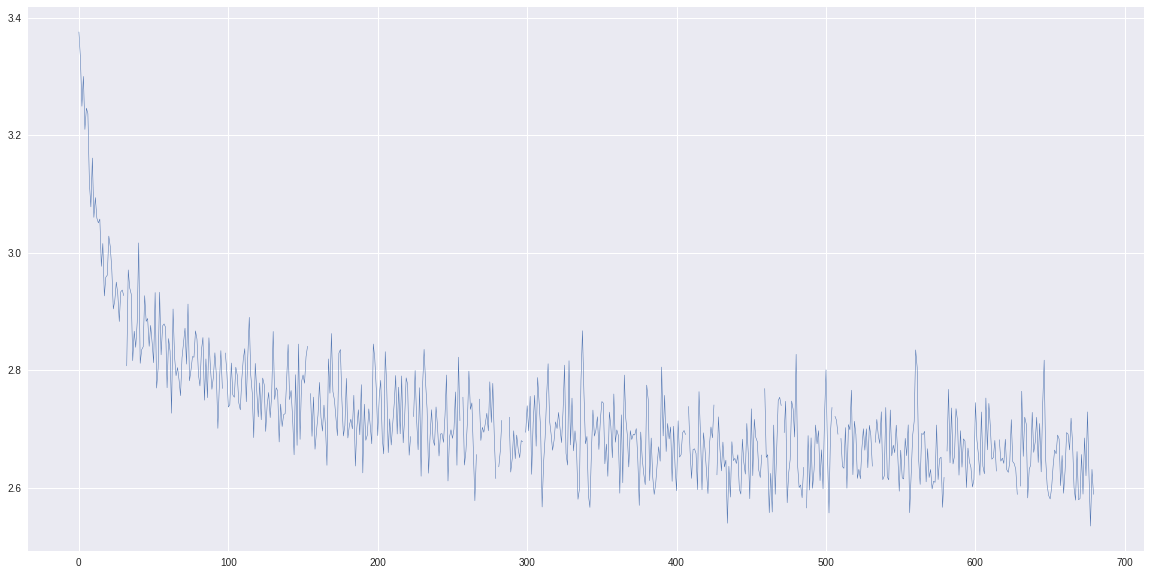

In [44]:
plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(losses)), losses, linewidth=0.5);  # overall training loss

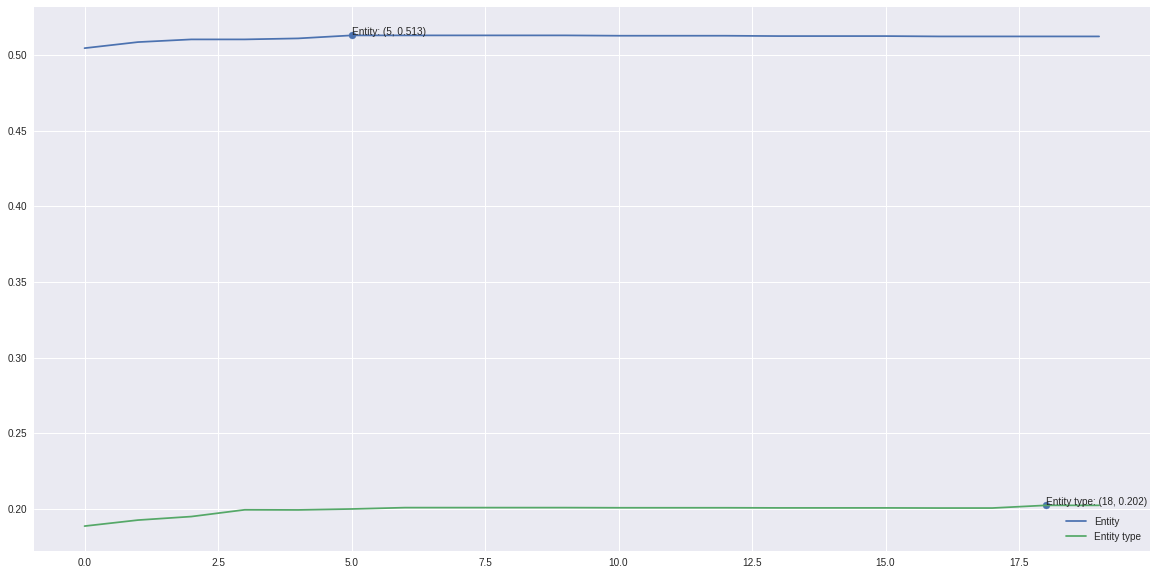

In [45]:
f_entity = [tup[0][-1] for tup in scores]
f_type = [tup[1][-1] for tup in scores]

x = [np.argmax(f_entity), np.argmax(f_type)]
y = [np.max(f_entity), np.max(f_type)]


plt.figure(figsize=(20, 10))
plt.plot(np.arange(n_epochs), f_entity, label='Entity')
plt.plot(np.arange(n_epochs), f_type, label='Entity type')

plt.scatter(x, y)
plt.annotate(f'Entity: ({x[0]}, {np.round(y[0], 3)})', (x[0], y[0]))
plt.annotate(f'Entity type: ({x[1]}, {np.round(y[1], 3)})', (x[1], y[1]))

plt.legend();

## Prediction

In [46]:
y1, y2 = forward(*model, x=X_val[0])
y_pred = predict(entity_mapping, entity_type_mapping, y1, y2)
y_true = val_labels[0]
for _pred, _true in zip(y_pred, y_true):
    print(_pred, _true, sep='\t')

B-NP	B-NP
B-NP	I-NP
B-NP	I-NP
B-NP	O
B-NP	B-NP
B-NP	B-VP
B-NP	I-VP
B-NP	B-ADVP
B-NP	O
B-NP	B-VP
B-NP	B-PP
B-NP	B-NP
B-NP	B-PP
B-NP	B-NP
B-NP	O


Check for class imbalance.

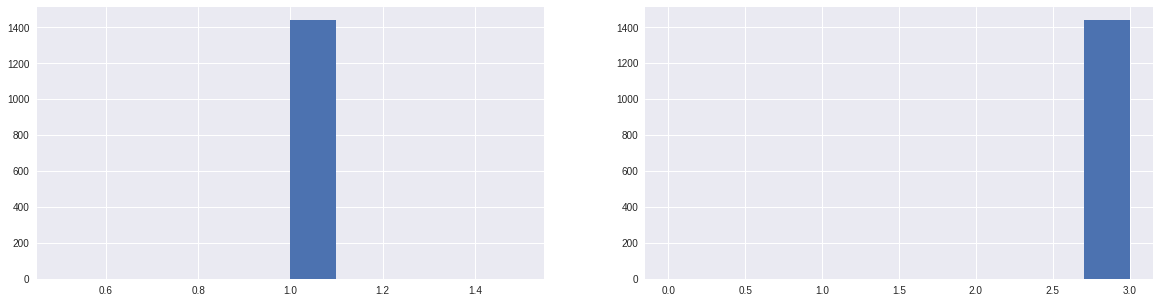

In [47]:
all_y1, all_y2 = [], []
for i in trange(len(X_val)):
    y1, y2 = forward(*model, x=X_val[i])
    all_y1.extend(np.argmax(y1, axis=1).flatten())
    all_y2.extend(np.argmax(y2, axis=1).flatten())


plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(all_y1)
plt.subplot(1, 2, 2)
plt.hist(all_y2);